In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

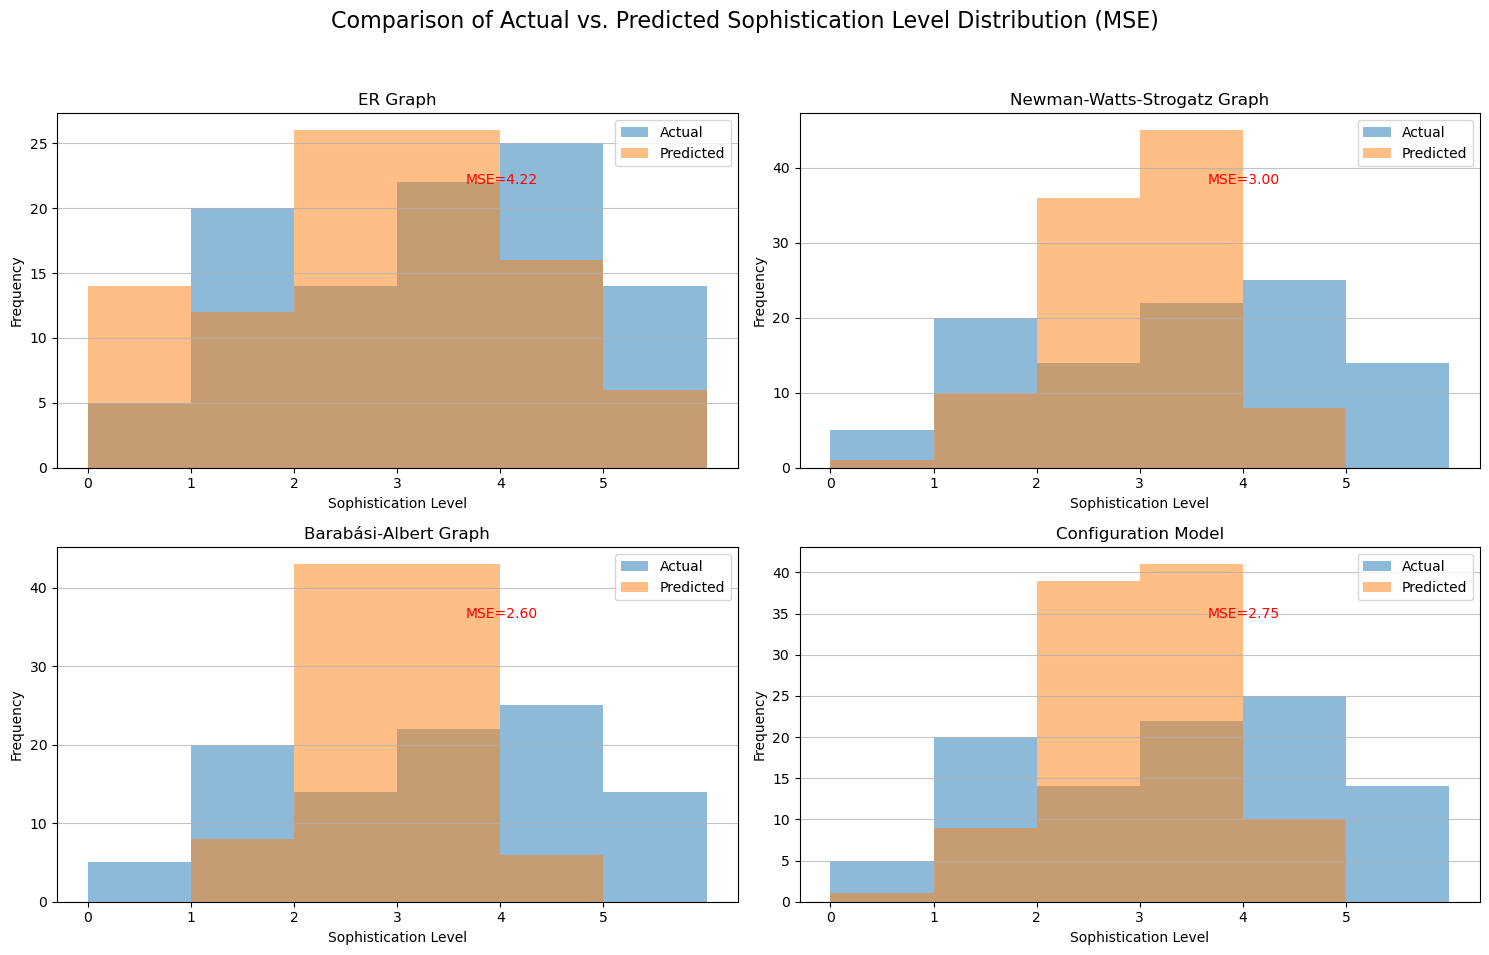

In [41]:
# Define the initial belief calculation function
def initial_belief_function(node, G, sophistication_levels):
    neighbors = list(G.neighbors(node))
    if len(neighbors) == 0:
        return np.random.rand()  # If no neighbors, assign a random initial belief
    else:
        neighbor_sophistication = [sophistication_levels[n] for n in neighbors]
        return np.mean(neighbor_sophistication)

# Define parameters
num_players = 100
k_max = 5

# Determine the number of step-0 thinkers (1 percent of players)
num_step_0 = int(0.05 * num_players)

# Generate sophistication levels for the rest of the players (non-step-0 thinkers)
sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

# Add step-0 thinkers to the sophistication levels
sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

# Shuffle the sophistication_levels to distribute step-0 thinkers randomly
np.random.shuffle(sophistication_levels)

# Initialize lists to store results and labels for the different network types
network_types = ['ER Graph', 'Newman-Watts-Strogatz Graph', 'Barabási-Albert Graph', 'Configuration Model']
results = []
mse_values = []

# Generate and evaluate beliefs for each network type
for network_type in network_types:
    if network_type == 'ER Graph':
        G = nx.erdos_renyi_graph(num_players, 0.02)
    elif network_type == 'Newman-Watts-Strogatz Graph':
        G = nx.newman_watts_strogatz_graph(num_players, 4, 0.2)
    elif network_type == 'Barabási-Albert Graph':
        G = nx.barabasi_albert_graph(num_players, 3)
    elif network_type == 'Configuration Model':
        avg_degree = 4
        degree_sequence = np.random.poisson(avg_degree, num_players)

        if sum(degree_sequence) % 2 != 0:
            degree_sequence[np.argmax(degree_sequence)] += 1

        G = nx.configuration_model(degree_sequence)

    beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
    predicted_beliefs = np.array(list(beliefs.values()))
    mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)

    results.append((predicted_beliefs, sophistication_levels))
    mse_values.append(mse)

# Create subplots for each network type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparison of Actual vs. Predicted Sophistication Level Distribution (MSE)', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    predicted_beliefs, actual_beliefs = results[i]
    difference = predicted_beliefs - actual_beliefs
    
    ax.hist(actual_beliefs, bins=range(k_max + 2), alpha=0.5, label='Actual')
    ax.hist(predicted_beliefs, bins=range(k_max + 2), alpha=0.5, label='Predicted')
    ax.set_xlabel('Sophistication Level')
    ax.set_ylabel('Frequency')
    ax.set_title(network_types[i], fontsize=12)
    ax.legend(loc='upper right')
    ax.set_xticks(range(k_max + 1))
    ax.grid(axis='y', alpha=0.75)
    ax.text(0.6, 0.8, f'MSE={mse_values[i]:.2f}', transform=ax.transAxes, fontsize=10, color='red')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('k-level synthetic experiments-random actual.png', dpi=600)
plt.show()


# ER Graph

In [47]:
# Define the initial belief calculation function based on sophistication level
def initial_belief_function(node, G, sophistication_levels):
    neighbors = list(G.neighbors(node))
    if len(neighbors) == 0:
        return np.random.rand()  # If no neighbors, assign a random initial belief
    else:
        player_level = sophistication_levels[node]
        mapped_levels = [min(player_level, neighbor_level) for neighbor_level in sophistication_levels[neighbors]]
        return np.mean(mapped_levels)  # Average over mapped sophistication levels

# Define parameters
num_players = 100
k_max = 5
er_probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]  # Different ER graph probabilities to test
iterations = 1000  # Number of iterations to average over

# Initialize a list to store the average MSE results for each ER graph probability
average_mse_results = []

for er_prob in er_probabilities:
    mse_sum = 0.0
    
    for _ in range(iterations):
        # Generate an Erdős-Rényi (ER) graph with the current probability
        G = nx.erdos_renyi_graph(num_players, er_prob)
        
        # Determine the number of step-0 thinkers (1 percent of players)
        num_step_0 = int(0.05 * num_players)

        # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
        sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

        # Add step-0 thinkers to the sophistication levels
        sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

        # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
        np.random.shuffle(sophistication_levels)
        
        # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
        beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
        
        # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
        predicted_beliefs = np.array(list(beliefs.values()))
        mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
        mse_sum += mse
    
    # Calculate the average MSE over iterations and append to the results list
    average_mse = mse_sum / iterations
    average_mse_results.append(average_mse)

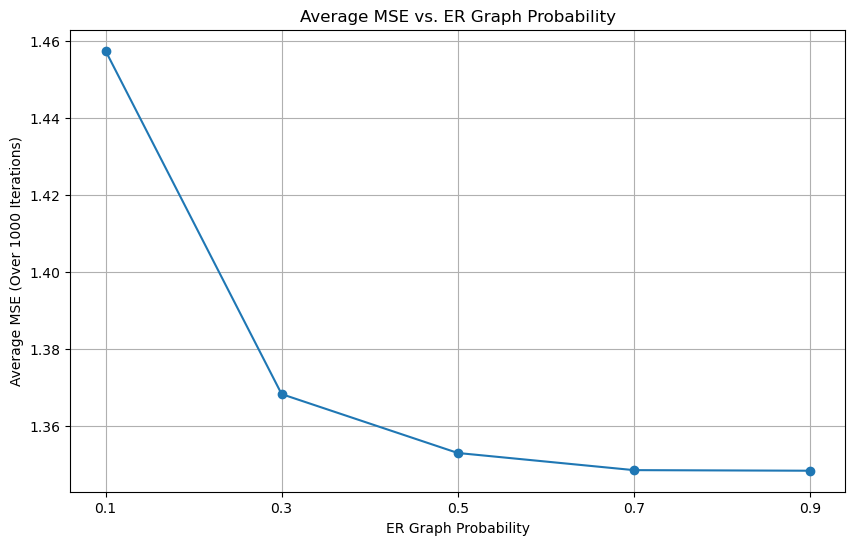

In [48]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(er_probabilities, average_mse_results, marker='o', linestyle='-')
plt.xlabel('ER Graph Probability')
plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
plt.xticks(er_probabilities)
plt.title(f'Average MSE vs. ER Graph Probability')
plt.grid(True)
plt.savefig('k-level synthetic experiments-ER graph probability.png', dpi=600)
plt.show()

# Watts Strogatz Graph

In [49]:
# Define parameters
num_players = 100
k_max = 5
ws_probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]  # Different Watts-Strogatz probabilities to test
iterations = 5000  # Number of iterations to average over

# Initialize a list to store the average MSE results for each Watts-Strogatz probability
average_mse_results = []

for ws_prob in ws_probabilities:
    mse_sum = 0.0
    
    for _ in range(iterations):
        # Generate a Watts-Strogatz small-world network with the current probability
        G = nx.newman_watts_strogatz_graph(num_players, 4, ws_prob)  # Adjust parameters as needed
        
        # Determine the number of step-0 thinkers (1 percent of players)
        num_step_0 = int(0.05 * num_players)

        # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
        sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

        # Add step-0 thinkers to the sophistication levels
        sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

        # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
        np.random.shuffle(sophistication_levels)

        # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
        beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
        
        # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
        predicted_beliefs = np.array(list(beliefs.values()))
        mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
        mse_sum += mse
    
    # Calculate the average MSE over iterations and append to the results list
    average_mse = mse_sum / iterations
    average_mse_results.append(average_mse)

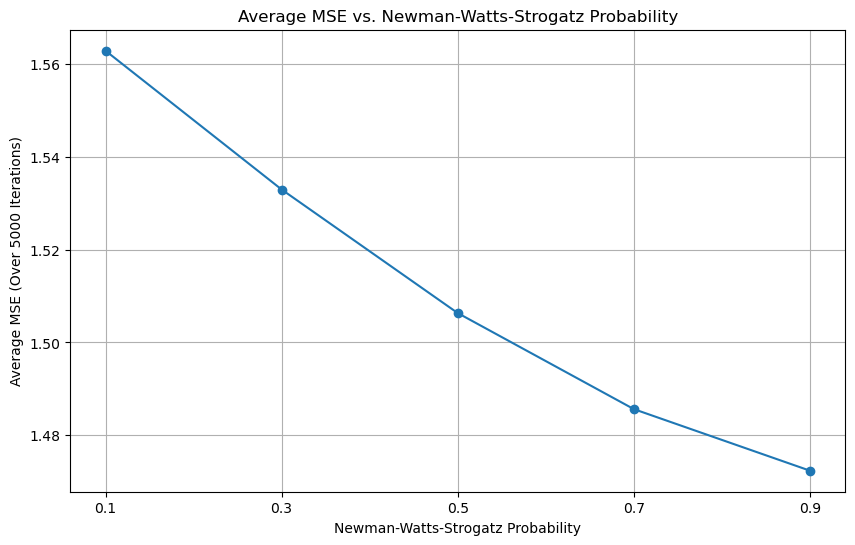

In [50]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ws_probabilities, average_mse_results, marker='o', linestyle='-')
plt.xlabel('Newman-Watts-Strogatz Probability')
plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
plt.xticks(ws_probabilities)
plt.title(f'Average MSE vs. Newman-Watts-Strogatz Probability')
plt.grid(True)
plt.savefig('k-level synthetic experiments-Newman-Watts-Strogatz probability.png', dpi=600)
plt.show()

# Barabasi Albert Graph

In [51]:
# Define parameters
num_players = 100
k_max = 5
ba_parameters = [1, 3, 5, 7, 10]  # Different Barabási-Albert parameters to test
iterations = 1000  # Number of iterations to average over

# Initialize a list to store the average MSE results for each Barabási-Albert parameter
average_mse_results = []

for ba_param in ba_parameters:
    mse_sum = 0.0
    
    for _ in range(iterations):
        # Generate a Barabási-Albert scale-free network with the current parameter
        G = nx.barabasi_albert_graph(num_players, ba_param)  # Adjust parameters as needed
        
        # Determine the number of step-0 thinkers (1 percent of players)
        num_step_0 = int(0.05 * num_players)

        # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
        sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

        # Add step-0 thinkers to the sophistication levels
        sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

        # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
        np.random.shuffle(sophistication_levels)
        
        # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
        beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
        
        # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
        predicted_beliefs = np.array(list(beliefs.values()))
        mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
        mse_sum += mse
    
    # Calculate the average MSE over iterations and append to the results list
    average_mse = mse_sum / iterations
    average_mse_results.append(average_mse)

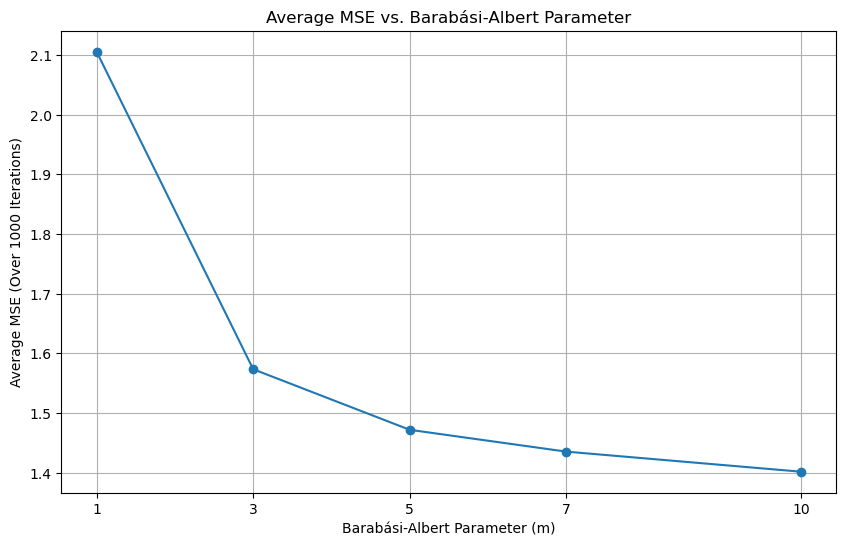

In [52]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ba_parameters, average_mse_results, marker='o', linestyle='-')
plt.xlabel('Barabási-Albert Parameter (m)')
plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
plt.xticks(ba_parameters)
plt.title(f'Average MSE vs. Barabási-Albert Parameter')
plt.grid(True)
plt.savefig('k-level synthetic experiments-Barabási-Albert parameter.png', dpi=600)
plt.show()

# Configuration Grpah

In [53]:
# Define parameters
num_players = 100
k_max = 5
average_degrees = [5, 10, 15, 20, 50]  # Average degree for the degree sequence

# Initialize a list to store the average MSE results for different ER graph probabilities
average_mse_results = []

# Number of iterations to average over
iterations = 1000

for avg_degree in average_degrees:
    
    mse_sum = 0.0
    
    for _ in range(iterations):
        # Generate a random degree sequence with the desired average degree
        degree_sequence = np.random.poisson(avg_degree, num_players)

        # Ensure that the sum of degrees is even (required for a valid CFG network)
        if sum(degree_sequence) % 2 != 0:
            degree_sequence[np.argmax(degree_sequence)] += 1

        # Generate a configuration model network with the degree sequence
        G_cfg = nx.configuration_model(degree_sequence)

        # Determine the number of step-0 thinkers (1 percent of players)
        num_step_0 = int(0.05 * num_players)

        # Generate sophistication levels for the rest of the players (non-step-0 thinkers)
        sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

        # Add step-0 thinkers to the sophistication levels
        sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

        # Shuffle the sophistication_levels to distribute step-0 thinkers randomly
        np.random.shuffle(sophistication_levels)
        
        # Initialize beliefs dictionary with initial beliefs based on neighbors' sophistication levels
        beliefs = {node: initial_belief_function(node, G_cfg, sophistication_levels) for node in G_cfg.nodes()}
        
        # Calculate the Mean Squared Error (MSE) between predicted beliefs and actual sophistication levels
        predicted_beliefs = np.array(list(beliefs.values()))
        mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
        
        mse_sum += mse
    
    # Calculate the average MSE over iterations and append to the results list
    average_mse = mse_sum / iterations
    average_mse_results.append(average_mse)

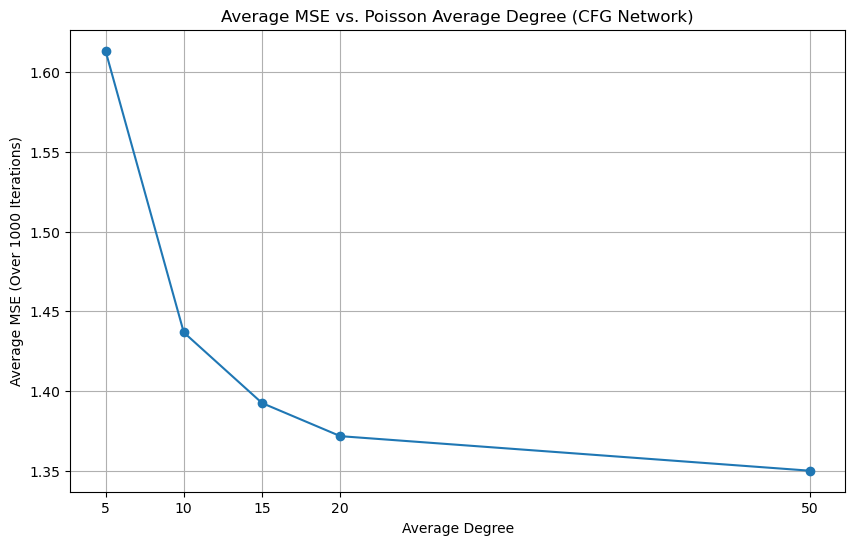

In [54]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(average_degrees, average_mse_results, marker='o', linestyle='-')
plt.xlabel('Average Degree')
plt.ylabel(f'Average MSE (Over {iterations} Iterations)')
plt.xticks(average_degrees)
plt.title(f'Average MSE vs. Poisson Average Degree (CFG Network)')
plt.grid(True)
plt.savefig('k-level synthetic experiments-CFG-Poisson graph probability.png', dpi=600)
plt.show()


# Comparison between all the graphs and the rate of improvement in the MSE

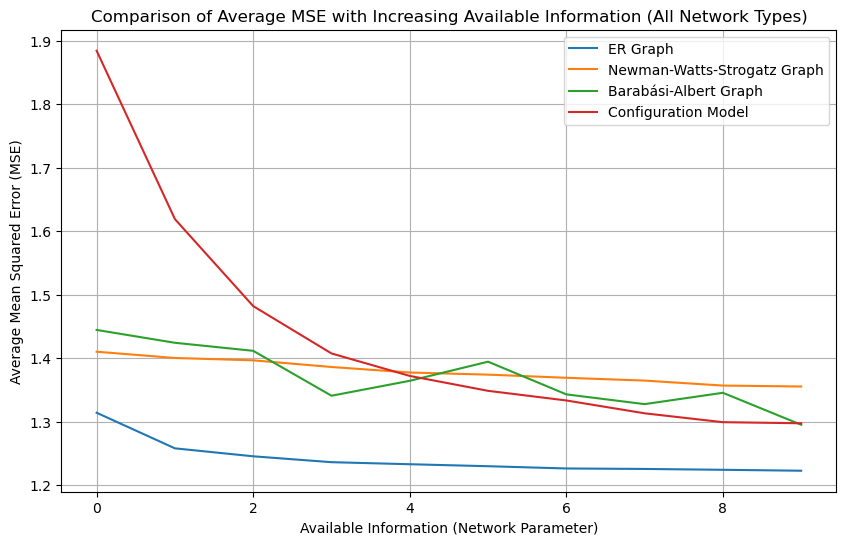

In [55]:
# Define parameters
num_players = 100
k_max = 5
num_iterations = 1000  # Number of iterations to average over

# Create a list to store results for different network types
network_types = ['ER Graph', 'Newman-Watts-Strogatz Graph', 'Barabási-Albert Graph', 'Configuration Model']
results = {network_type: [] for network_type in network_types}

# Determine the number of step-0 thinkers (1 percent of players)
num_step_0 = int(0.05 * num_players)

# Generate sophistication levels for the rest of the players (non-step-0 thinkers)
sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

# Add step-0 thinkers to the sophistication levels
sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

# Shuffle the sophistication_levels to distribute step-0 thinkers randomly
np.random.shuffle(sophistication_levels)

# Initialize the available_information variable for each network type
er_parameters = [i * 0.1 for i in range(1, 11)]  # ER graph parameter
ws_probabilities = [i * 0.05 for i in range(1, 11)]  # Watts-Strogatz probability
ba_degrees = [i + 2 for i in range(1, 11)]  # Barabási-Albert degree
cfg_avg_degrees = [i + 2 for i in range(1, 11)]  # Configuration Model average degree

# Run experiments and average results over iterations
for network_type in network_types:
    avg_mse_values = []

    for _ in range(num_iterations):
        mse_values = []

        if network_type == 'ER Graph':
            for param in er_parameters:
                G = nx.erdos_renyi_graph(num_players, param)
                beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
                predicted_beliefs = np.array(list(beliefs.values()))
                mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
                mse_values.append(mse)

        elif network_type == 'Newman-Watts-Strogatz Graph':
            for prob in ws_probabilities:
                G = nx.newman_watts_strogatz_graph(num_players, 4, prob)
                beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
                predicted_beliefs = np.array(list(beliefs.values()))
                mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
                mse_values.append(mse)

        elif network_type == 'Barabási-Albert Graph':
            for degree in ba_degrees:
                G = nx.barabasi_albert_graph(num_players, degree)
                beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
                predicted_beliefs = np.array(list(beliefs.values()))
                mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
                mse_values.append(mse)

        elif network_type == 'Configuration Model':
            for avg_degree in cfg_avg_degrees:
                degree_sequence = np.random.poisson(avg_degree, num_players)

                if sum(degree_sequence) % 2 != 0:
                    degree_sequence[np.argmax(degree_sequence)] += 1

                G = nx.configuration_model(degree_sequence)
                beliefs = {node: initial_belief_function(node, G, sophistication_levels) for node in G.nodes()}
                predicted_beliefs = np.array(list(beliefs.values()))
                mse = np.mean((predicted_beliefs - sophistication_levels) ** 2)
                mse_values.append(mse)

        avg_mse_values.append(mse_values)

    # Calculate the average MSE values over iterations for each parameter setting
    avg_mse = np.mean(np.array(avg_mse_values), axis=0)
    results[network_type] = avg_mse

# Create a plot to compare all network types
plt.figure(figsize=(10, 6))
for network_type in network_types:
    plt.plot(results[network_type], label=network_type)

plt.xlabel('Available Information (Network Parameter)')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('Comparison of Average MSE with Increasing Available Information (All Network Types)')
plt.legend()
plt.grid()
plt.savefig('k-level synthetic experiments-All network types.png', dpi=600)
plt.show()


# Guessing Game

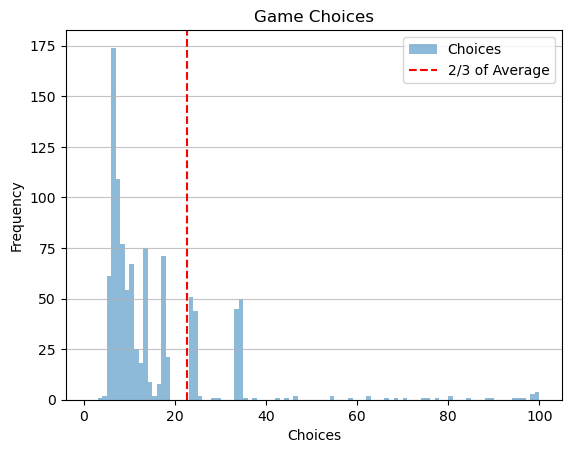

Actual 2/3 of the Average: 22.677


In [56]:
# Define the choice function based on sophistication level and neighbors' sophistication
def choice(node, G, sophistication_levels):
    player_level = sophistication_levels[node]
    
    if player_level == 0:
        return random.randint(1, 100)  # Step-0 thinkers choose randomly between 1 and 100
    else:
        neighbor_average = initial_belief_function(node, G, sophistication_levels)
        return int((2/3) ** neighbor_average * 50)

# Example usage:
num_players = 1000
k_max = 10

# Generate a random graph representing player connections
G = nx.erdos_renyi_graph(num_players, 0.2)

# Determine the number of step-0 thinkers (1 percent of players)
num_step_0 = int(0.05 * num_players)

# Generate sophistication levels for the rest of the players (non-step-0 thinkers)
sophistication_levels = np.random.randint(1, k_max + 1, num_players - num_step_0)

# Add step-0 thinkers to the sophistication levels
sophistication_levels = np.concatenate((sophistication_levels, np.zeros(num_step_0)))

# Shuffle the sophistication_levels to distribute step-0 thinkers randomly
np.random.shuffle(sophistication_levels)

# Initialize a list to store players' choices
choices = []

# Iterate through all nodes and record their choices
for node in G.nodes():
    player_choice = choice(node, G, sophistication_levels)
    choices.append(player_choice)

# Calculate the actual 2/3 of the average
actual_average = np.mean(choices) * 3/2

# Plot a histogram of choices and mark the actual 2/3 of the average with a dashed line
plt.hist(choices, bins=range(1, 101), alpha=0.5, label='Choices')
plt.axvline(x=actual_average, color='r', linestyle='dashed', label='2/3 of Average')
plt.xlabel('Choices')
plt.ylabel('Frequency')
plt.title('Game Choices')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)

plt.show()

# Print the actual 2/3 of the average
print(f"Actual 2/3 of the Average: {actual_average}")

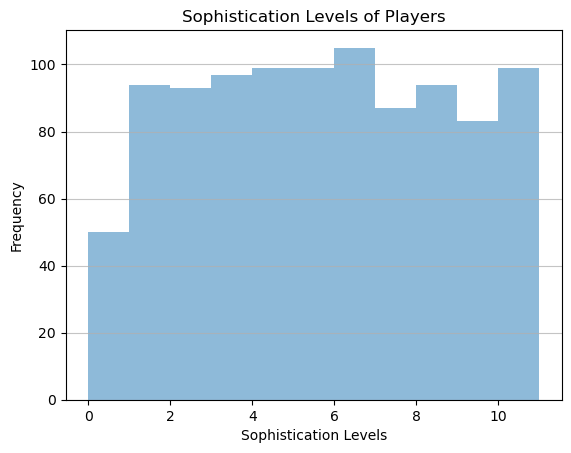

In [57]:
# Plot the histogram of sophistication levels
plt.hist(sophistication_levels, bins=range(k_max + 2), alpha=0.5)
plt.xlabel('Sophistication Levels')
plt.ylabel('Frequency')
plt.title('Sophistication Levels of Players')
plt.grid(axis='y', alpha=0.75)

plt.show()